![Google](https://upload.wikimedia.org/wikipedia/commons/2/2f/Google_2015_logo.svg)
# **Deep Learning Summer Day con Google Cloud**
23 de Julio de 2020

Bienvenido a este notebook del Deep Learning Summer Day con Google Cloud, donde vamos a entrenar a una red neuronal a jugar al juego spot it.
El objetivo del juego es encontrar el simblo repetido en cada par de cartas, solo hay uno, el que primero lo encuentre gana!
![Spoit it](https://thumbs-prod.si-cdn.com/XYC9Mfk49L1nT3hbiJrDjYTHl2g=/800x600/filters:no_upscale():focal(627x536:628x537)/https://public-media.si-cdn.com/filer/b7/16/b716f299-f842-4133-822d-efd55e2adc3f/1359415822_w640_h640_spot_it_card_game.jpg)

Notebook parcialmente basado en [Medium post](https://towardsdatascience.com/how-i-learned-my-computer-to-play-spot-it-using-opencv-and-deep-learning-ad1f017a3ec3)

Atendiendo al ciclo de vida clasico de desarrollos ML, este notebook consta de tres secciones:
* FASE 1: Fase de captura y preparacion de datos
* FASE 2: Fase de entrenamiento
* FASE 3: Fase de prediccion

Primero vamos a instalar algunos paquetes que nos serviran para el procesado de imagenes.
```
paquetes necesarios: imutils
```
Tambien vamos a crear un directorio en nuestro entorno local para albergar los datos de entrenamiento. Para ello creamos simplemente una carpeta llamada symbols utilizando el comando:

```
mkdir symbols
```

In [ ]:
!pip install imutils

## FASE 1: Fase de captura y preparacion de datos

Los datos de entrenamiento, validacion y test se han descargado del repositorio de github.
Vamos a ver la pinta de algunas de las imagenes que hemos copiado, por ejemplo la imagen: 

```
symbols/train/art/19_IMG_20200719_113814.jpg_processed.jpg_icon2.jpg
```

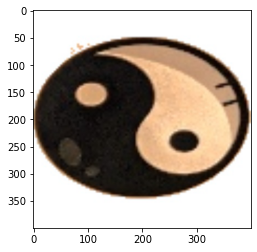

In [1]:
import matplotlib.pyplot as plt
import cv2
imagen='symbols/validation/yinyan/32_MVIMG_20200719_113301.jpg_processed.jpg_icon0.jpg'
imagen_cv2 = cv2.imread(imagen)
plt.imshow(imagen_cv2)

Se ha ejecutado ya un preprocesado de los datos, segun el codigo que esta en el notebook spot_id_dataprep.ipnyb, basicamente es un extractor de los simbolos dadas fotos de las tarjetas del juego.

#### Knowledge check: por que hemos dividido los datos en tres carpetas?

Tenemos nuestros datos de entrenamiento y validacion preparados, ya podemos empezar a entrenar una red neuronal. Para ello vamos a utilizar tensorflow. La arquitectura de la red que vamos a desplegar es:
* 6 capas de convolucion + MaxPooling con 32,64,128,256,256 y 128 filtros de 3x3. Funcion de activacion reLu
* 1 capa Flatten
* 1 capa de regularizacion Dropout
* 1 Capa totalmente conectadas
* 1 Capa totalmente conectada de salida
Optimizador: RMSProp
Funcion de perdida: categorical crossentropy

## FASE 2: Fase de entrenamiento

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
model.add(layers.MaxPooling2D((2, 2)))  
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(57, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

#### Knowledge check: Cual son los 'output shapes' capa por capa?
#### Knowledge check: Que quiere decir lr = 1e-4?
#### Knowledge check: Por que tenemos 57 neuronas en la capa de salida?

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 256)       2

Ahora vamos a introducir los datos de entrenamiento y validacion utilizando las funciones de preparacion de datos de Tensorflow:


```
ImageDataGenerator
.flow_from_directory
```



In [6]:
train_dir = 'symbols/train'
validation_dir = 'symbols/validation'
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(400,400), batch_size=10, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(400,400), batch_size=5, class_mode='categorical')

Found 1659 images belonging to 57 classes.
Found 486 images belonging to 57 classes.


#### Cual es el cometido de esta linea de codigo?
```
(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
```

Todo listo para lanzar el proceso de entrenamiento, aseguremonos que estamos utilizando un acelerador ASIC (e.g. GPU)

In [7]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
  5/100 [>.............................] - ETA: 4:08 - loss: 4.0491 - acc: 0.0250   

KeyboardInterrupt: 

Vamos a visualizar las metricas de convergencia del modelo, guardadas en la variable history

In [8]:
print(history.history.keys())
# Acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# sLoss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

Copiamos el modelo pre-entrenado desde GCS a nuestro notebook

In [ ]:
model = tf.keras.models.load_model('spot_model')

## FASE 3: Fase de prediccion 

En esta fase vamos a realizar las predicciones, puedes adaptar la variable predict_filename a la imagen que quieras o subir una nueva imagen.

Para podere hacer la prediccion debemos reproducir el proceso de preparacion de datos para extraer los simbolos de la imagen, para ello vamos a apoyarnos en la libreria cv2 e imutils.

En la carpeta test hay un conjunto de imagenas para realizar las predicciones.

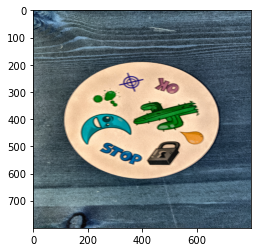

In [3]:
import cv2
import matplotlib.pyplot as plt
predict_dir = 'symbols/test/'
predict_filename = 'IMG_20200719_113535.jpg'
image = cv2.imread(predict_dir+predict_filename)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
limg = cv2.merge((cl,a,b))
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
resized = cv2.resize(final, (800, 800))
plt.imshow(resized)

In [4]:
import imutils
import numpy as np
import  cv2
!rm -Rf predictions
!mkdir -p predictions
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY)[1]
## find contours
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output = image.copy()
## draw contours on image
for c in cnts:
    cv2.drawContours(output, [c], -1, (255, 0, 0), 3)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    mask = np.zeros(gray.shape,np.uint8)
    mask = cv2.drawContours(mask, [cnts], -1, 255, cv2.FILLED)
    fg_masked = cv2.bitwise_and(image, image, mask=mask)
    mask = cv2.bitwise_not(mask)
    bk = np.full(image.shape, 255, dtype=np.uint8)
    bk_masked = cv2.bitwise_and(bk, bk, mask=mask)
    final = cv2.bitwise_or(fg_masked, bk_masked)
    gray = cv2.cvtColor(final, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 195, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.bitwise_not(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    i = 0
    for c in cnts:
        if cv2.contourArea(c) > 1000:
            mask = np.zeros(gray.shape, np.uint8)
            mask = cv2.drawContours(mask, [c], -1, 255, cv2.FILLED)
            fg_masked = cv2.bitwise_and(image, image, mask=mask)
            mask = cv2.bitwise_not(mask)
            bk = np.full(image.shape, 255, dtype=np.uint8)
            bk_masked = cv2.bitwise_and(bk, bk, mask=mask)
            finalcont = cv2.bitwise_or(fg_masked, bk_masked)
            output = finalcont.copy()
            x,y,w,h = cv2.boundingRect(c)
            if w < h:
                x += int((w-h)/2)
                w = h
            else:
                y += int((h-w)/2)
                h = w
            roi = finalcont[y:y+h, x:x+w]
            try:
                roi = cv2.resize(roi, (400,400))
                cv2.imwrite('predictions/'+predict_filename+'_icon'+str(i)+'.jpg', roi)
            except Exception:
                pass
            i += 1

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model('spot_model')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('predictions',target_size=(400, 400),batch_size=10,class_mode='binary',shuffle=False)
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
predicted_probabilities = np.max(pred,axis=1)
predicted_class_indices = np.argmax(pred,axis=1)

Found 0 images belonging to 0 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


ValueError: Asked to retrieve element 0, but the Sequence has length 0

Valores de referencia para la clasificacion:
* 1 - Ajedrez
* 2 - Ancla
* 3 - Araña
* 4 - Arbol
* 5 - ART
* 6 - Biberon
* 7 - Bomba
* 8 - Bombilla
* 9 - Cactus
* 10 - Calavera
* 11 - Candado
* 12 - Coche
* 13 - Coponieve
* 14 - Corazon
* 15 - Cubito
* 16 - Delfin
* 17 - Diana
* 18 - Dragon
* 19 - Exclamacion
* 20 - Fantasmita
* 21 - Fuego
* 22 - Gafas sol
* 23 - Gato
* 24 - Globo
* 25 - Gota
* 26 - Hombre
* 27 - Iglu
* 28 - Interrogacion
* 29 - Labios
* 30 - Lapiz
* 31 - Llave
* 32 - Luna
* 33 - Mancha
* 34 - Mano
* 35 - Manzana
* 36 - Maple
* 37 - Margarita
* 38 - Mariquita
* 39 - Musica
* 40 - Ojo
* 41 - OK
* 42 - Payaso
* 43 - Perro
* 44 - Queso
* 45 - Rayo
* 46 - Reloj
* 47 - snowman
* 48 - Sol
* 49 - Stop
* 50 - Tela araña
* 51 - Tijeras
* 52 - Trebol
* 53 - TRex
* 54 - Vela
* 55 - Yin-yan
* 56 - Zanahoria
* 57 - Zebra

In [5]:
print(predicted_probabilities)

[0.99444735 0.97436327 0.99990046 0.99999917 0.97394955 1.
 0.99999976 0.5248283  0.4861112  0.8156704 ]


In [6]:
print(predicted_class_indices)

[ 9 32 11 48  0 25 17 35 33 19]
